In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from time import time
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn
from torch import distributions
from torch.distributions import (
    Normal,
    MultivariateNormal,
    Uniform,
    TransformedDistribution,
    SigmoidTransform,
)
from torch.nn.parameter import Parameter
from torch.optim.optimizer import Optimizer, required

from nflib.flows import (
    AffineConstantFlow,
    ActNorm,
    Invertible1x1Conv,
    NormalizingFlow,
    NormalizingFlowModel,
)
from nflib.spline_flows import NSF_CL

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#torch.cuda.set_device(device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
elif device.type == "cpu":
    print('Using the cpu...')

# choose data here
spectra = np.load("./data/X_train_payne_region.npy")
spectra = spectra.T
print(spectra.shape)

#use even number of dimensions, smaller number for quick debugging
spectra = spectra[:, 1:]
spectra = torch.Tensor(spectra)
spectra = spectra - 0.5
dim = spectra.shape[-1]
print(dim)

# choose prior here
base_mu, base_cov = torch.zeros(dim).to(device), torch.eye(dim).to(device)
prior = MultivariateNormal(base_mu, base_cov)

# configure the normalising flow
nfs_flow = NSF_CL
nflows = 5
hidden_dim = 16

flows = [nfs_flow(dim=dim, device=device, K=8, B=3, hidden_dim=hidden_dim) for _ in range(nflows)] #things to change> maybe more is needed??!
convs = [Invertible1x1Conv(dim=dim, device=device) for _ in flows]
norms = [ActNorm(dim=dim, device=device) for _ in flows]
flows = list(itertools.chain(*zip(norms, convs, flows)))

# initialise the model
model = NormalizingFlowModel(prior, flows, device=device)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-6, weight_decay=1e-5)  # todo tune WD
#print("number of params: ", sum(p.numel() for p in model.parameters()))


Using the cpu...
(1000, 1353)
1352


In [4]:
PATH = "model_test_joint_11.pt"

In [5]:
state_dict = torch.load(PATH, map_location=torch.device('cpu'))

model.load_state_dict(state_dict)

model.eval()

NormalizingFlowModel(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=676, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=15548, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=676, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): Leak

In [ ]:
for i, j in enumerate(train_loader):
    first_batch = j
    
    break
    
model(first_batch)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    spectra, batch_size=100, shuffle=True, pin_memory=True)

In [6]:


zs = model.sample(100)
z = zs[-1]
z = z.to('cpu')
z = z.detach().numpy()

 ...]

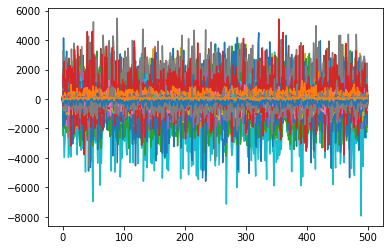

In [7]:
plt.plot(z)